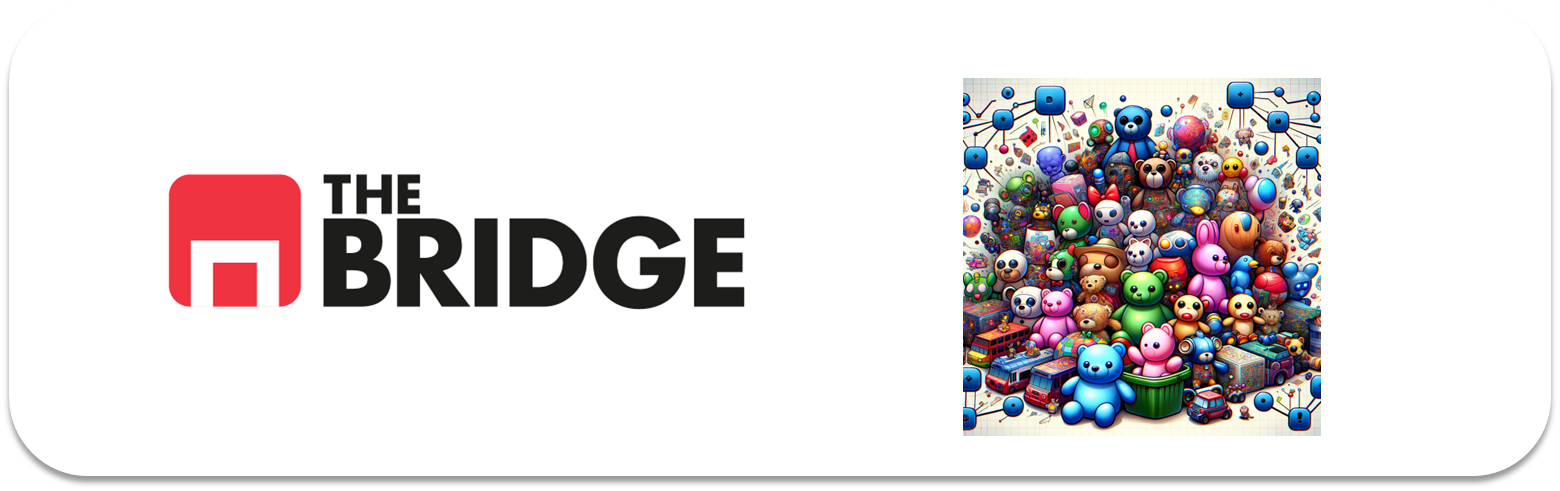

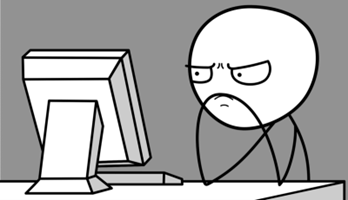

## PRACTICA OBLIGATORIA: DBSCAN y CLUSTERING JERARQUICO

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

### Parte I. Modelado

#### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferncia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vostros podéis ayudarles a encontrar algún tipo de segmentación que luego ello se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cual deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es espculativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar porqué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


### Cargar datos, visualizar.

In [4]:
df_empo = pd.read_csv("./data/empowering_drinks.csv", delimiter="|")
df_empo.head()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.518613,0.232053,1.034819,1.013009,0.251717
1,0.246290,-0.827996,0.733629,0.965242,-0.293321
2,0.196879,1.109334,1.215533,1.395148,0.269020
3,1.691550,0.487926,1.466525,2.334574,1.186068
4,0.295700,1.840403,0.663351,-0.037874,-0.319276


In [5]:
df_empo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               153 non-null    float64
 1   Vitamínas del grupo B  153 non-null    float64
 2   Cafeína                153 non-null    float64
 3   Ácido Cítrico          153 non-null    float64
 4   Taurina                153 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB


array([[<Axes: title={'center': 'Azúcares'}>,
        <Axes: title={'center': 'Vitamínas del grupo B'}>],
       [<Axes: title={'center': 'Cafeína'}>,
        <Axes: title={'center': 'Ácido Cítrico'}>],
       [<Axes: title={'center': 'Taurina'}>, <Axes: >]], dtype=object)

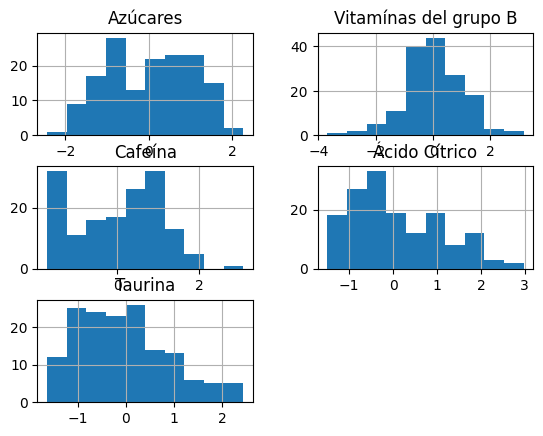

In [7]:
df_empo.hist()

Con una primera visualizacion se observa que:  
Que todas las variales son tipo float.  
Que todas las variables son numericas continuas.  
QUe las variables tienen valores negativos y ceros.  
Que no hay variables categóricas.  
Que no hay nulos.

In [8]:
train_set = df_empo.copy()

### MiniEDA: Selección de features

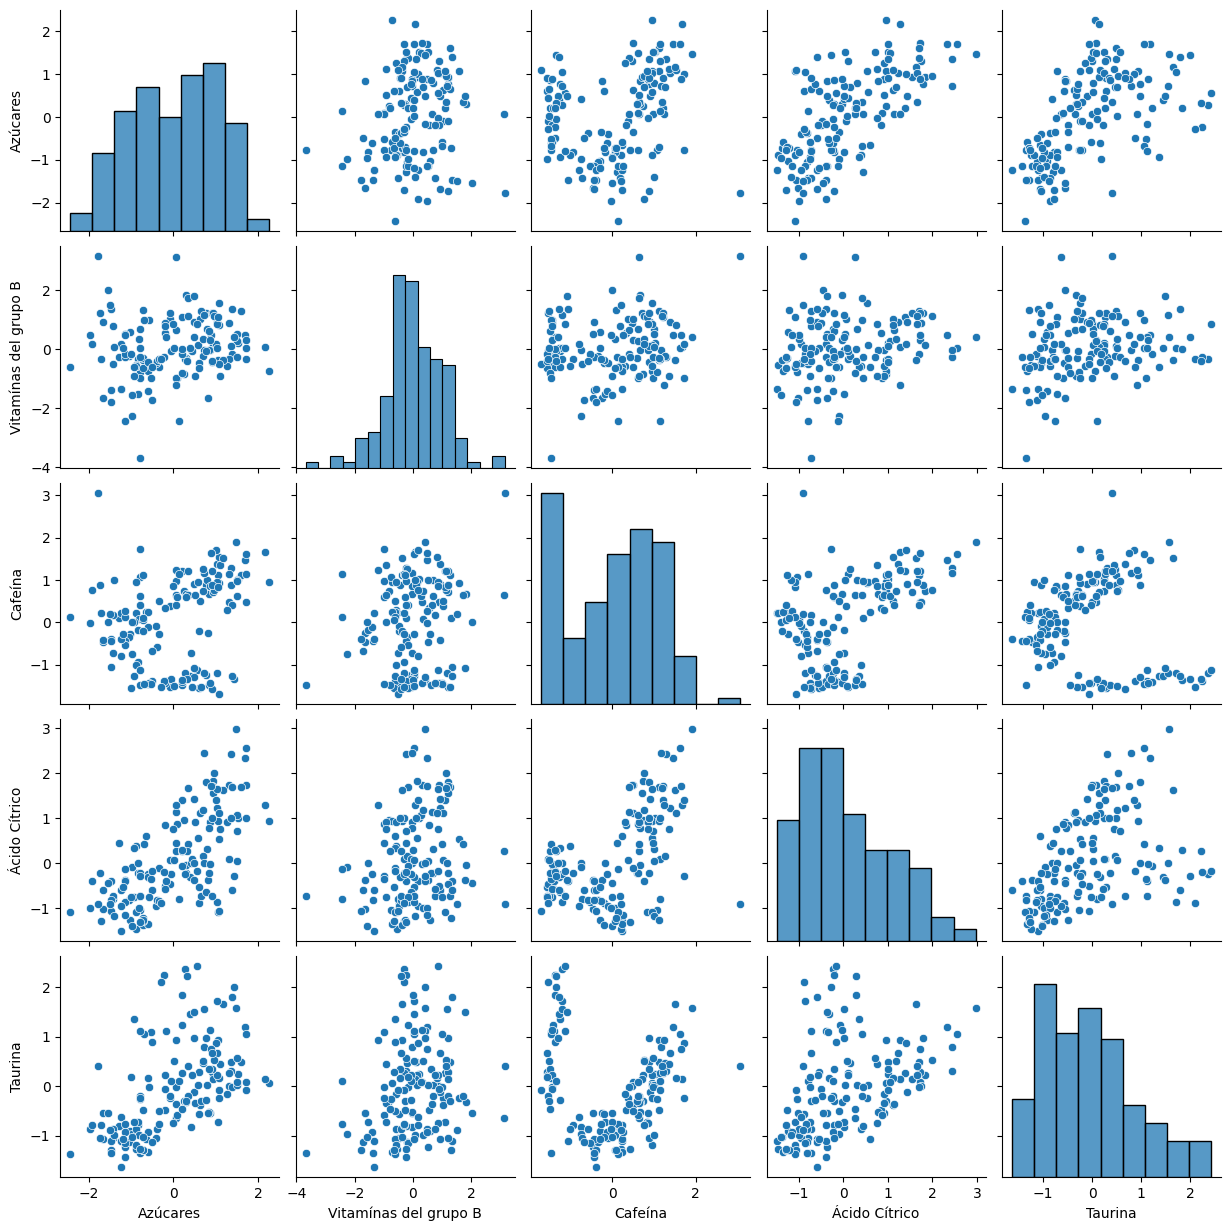

In [9]:
sns.pairplot(train_set)

Vemos que casi todos los pares de variables presentan agrupaciones interesantes y de correlacion.  
Excepto los pares que contienen a las Vitaminas del grupo, al parecer tienen poca impacto en la definicion del dataset. Por lo que la podríamos descartar de las variables seleccionadas.

In [12]:
features_sel = train_set.columns.to_list()
features_sel.remove("Vitamínas del grupo B")
features_sel

['Azúcares', 'Cafeína', 'Ácido Cítrico', 'Taurina']

### Tratamiento de Features.

Verificamos la distribucion de las variables seleccionadas y vemos que ya están estandarizadas con un Standard scaler porque vemos la media cercana a cero y la desviacion estandar cercana a 1

In [14]:
train_set[features_sel].describe()

,Azúcares,Cafeína,Ácido Cítrico,Taurina
count,153.000000,153.000000,153.000000,153.000000
mean,0.019231,0.041057,0.080022,-0.044088
std,1.026182,1.040928,1.009450,0.934399
min,-2.434235,-1.695971,-1.493188,-1.634288
25%,-0.816038,-1.043392,-0.738463,-0.799428
50%,0.061000,0.211566,-0.165254,-0.154899
75%,0.876275,0.894264,0.917474,0.493956
max,2.259772,3.062832,2.971473,2.431870


### Selección de modelos, selección de hiperparámetros

Elegimos el modelo DBSCAN y el modelo de Clustering Jerárquico Aglomerativo.

### DBSCAN

Hacemos una busqueda del mejor hiperparametro  eps para el modelo DBSCAN

In [129]:
from sklearn.cluster import DBSCAN

min_samples = 2  * len(train_set[features_sel].columns)
for eps in np.arange(0.001,3,0.01):
    modelo = DBSCAN(eps=eps, min_samples = min_samples)
    modelo.fit(train_set[features_sel])
    anomalias = (modelo.labels_ == -1).sum()/len(modelo.labels_)
    #print(anomalias,"%\n")
    if anomalias < 0.13:
        break

print(modelo)
print(anomalias)
best_eps = modelo.eps

DBSCAN(eps=0.8609999999999999, min_samples=8)
0.12418300653594772


In [130]:
pd.unique(modelo.labels_)

array([ 0, -1,  1,  2], dtype=int64)

In [131]:
modelo.labels_

array([ 0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  1, -1, -1,  1,  0, -1, -1,  1,  1, -1, -1,
        0,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  0,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2, -1,  2,  2,  2,  2, -1, -1,  2,  2,  2,  2, -1,  2],
      dtype=int64)

Para el modelo DBSCAN los hiperparámetros seleccionados fueron:  
eps=0.8609999999999999, min_samples=8  
Ya que cumplen con un porcentaje de nulos menor de 13%  
Elejimos min_samples = 8 porque se recomienda el doble de los features usadas.

#### Entrenamiento, visualización de resultados con DBSCAN

In [132]:
df_empo_bck = df_empo.copy()

In [133]:
df_empo["Cluster_dbscan"] = modelo.labels_

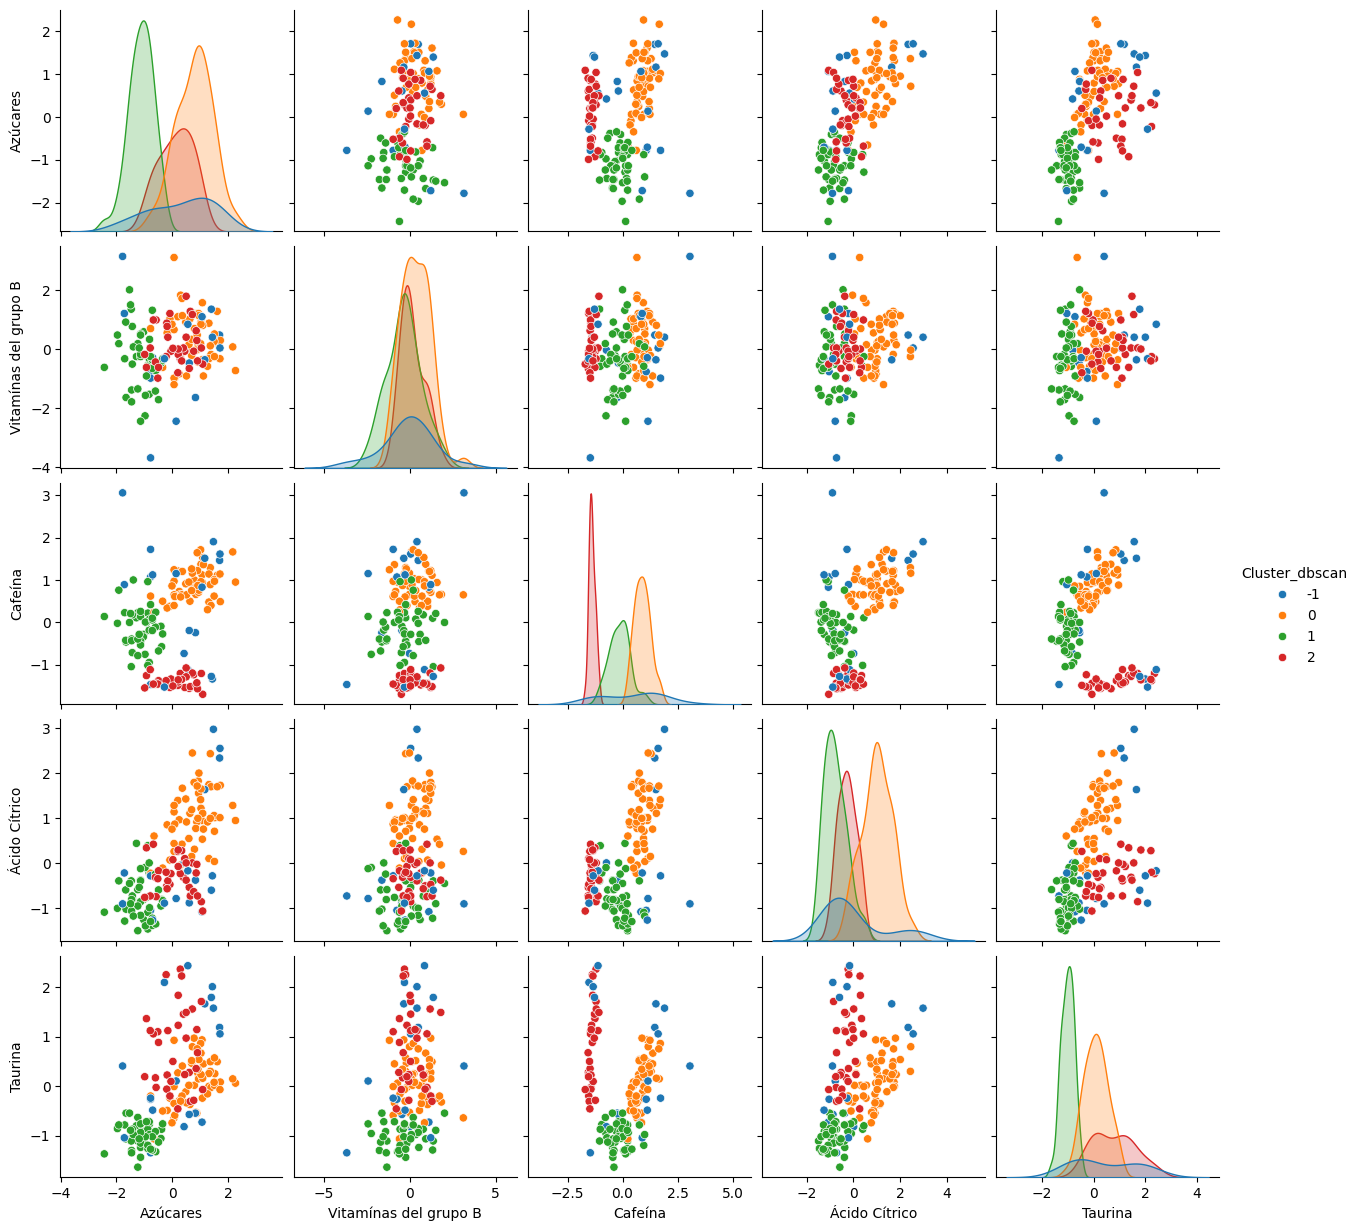

In [135]:
sns.pairplot(df_empo,hue="Cluster_dbscan",palette="tab10")

Aquí habría que aplicar una estrategia de asignacion de las anomalías a una de los cluster mas cercanos al punto. Pero de momento con esta segmentacion inicial nos vale.

### Clustering Jerárquico Aglomerativo

Hacemos el dendograma

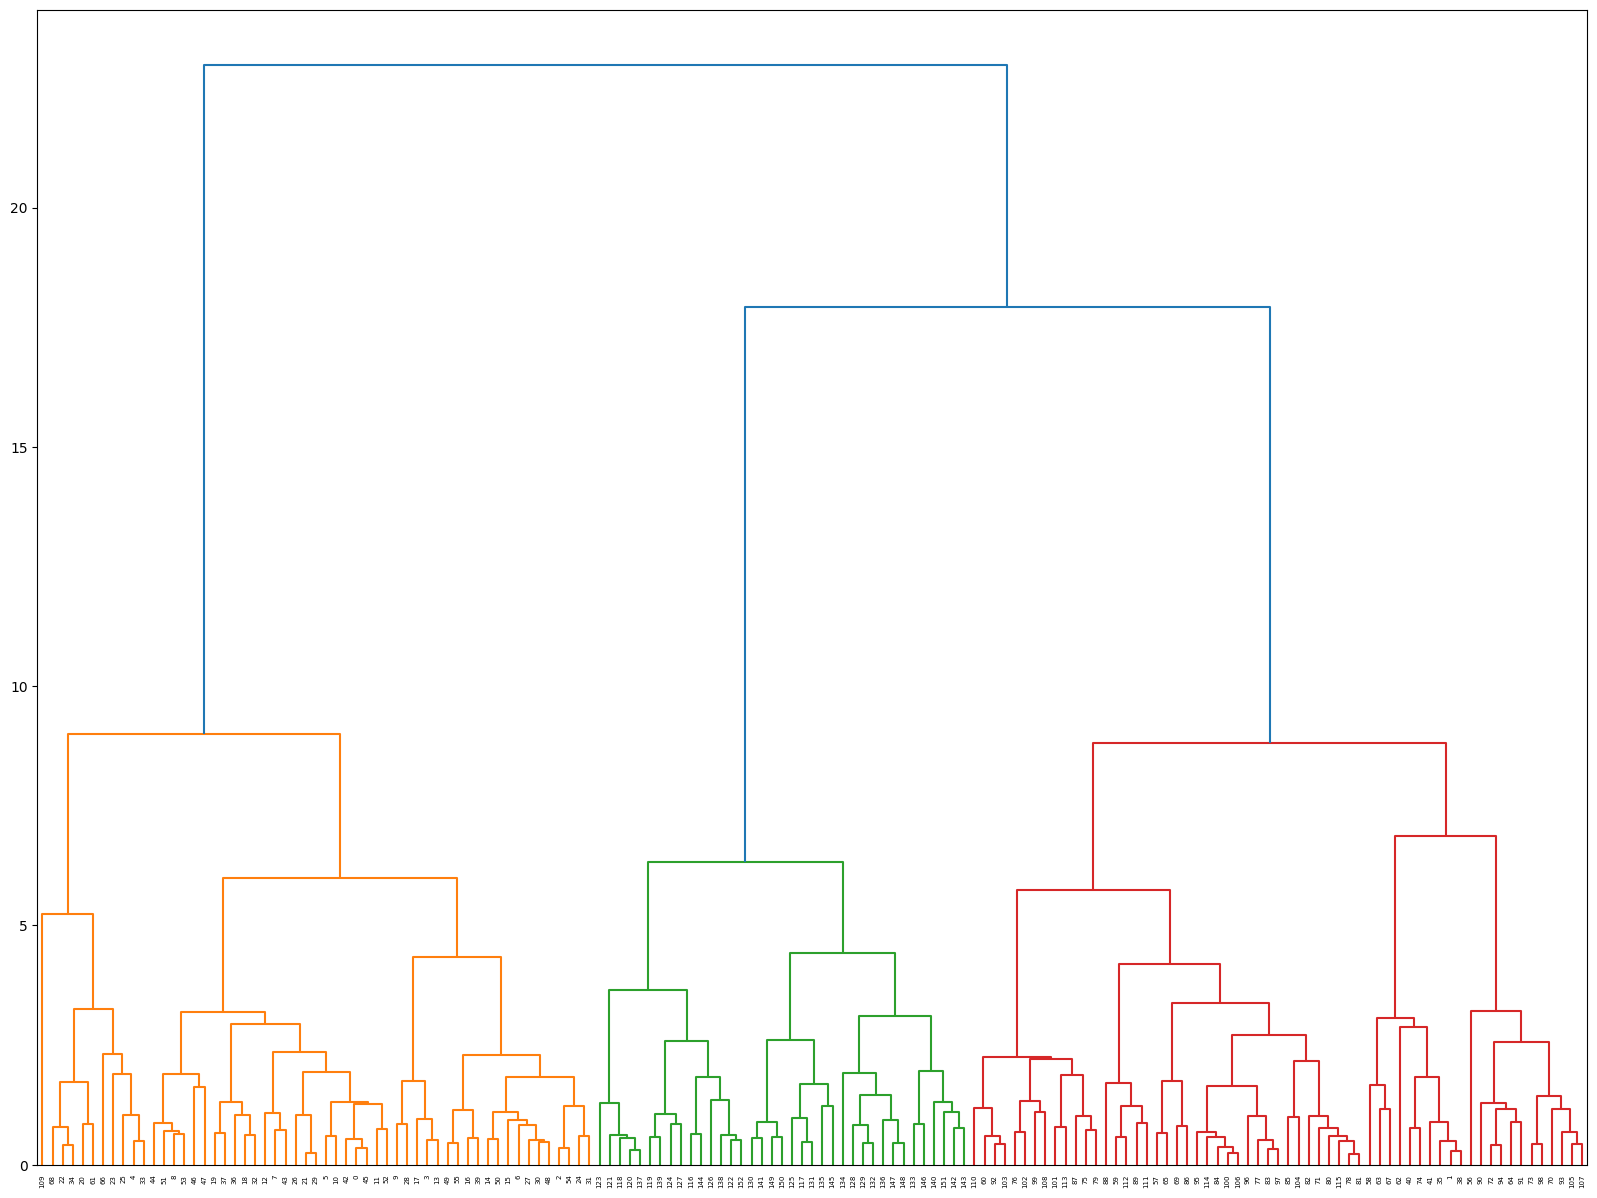

In [146]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(20, 15))
clusters = shc.linkage(train_set,method="ward",metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()

Probamos el tipo de metodo o linkage tanto con ward como average. Nos quedamos con ward que separó mejor en este caso.

Elegimos la distancia horizontal de corte de 17.5 de modo que cruce un minimo numero de lineas verticales de modo que los cluster esten suficientemente alejados.  
Y la graficamos.

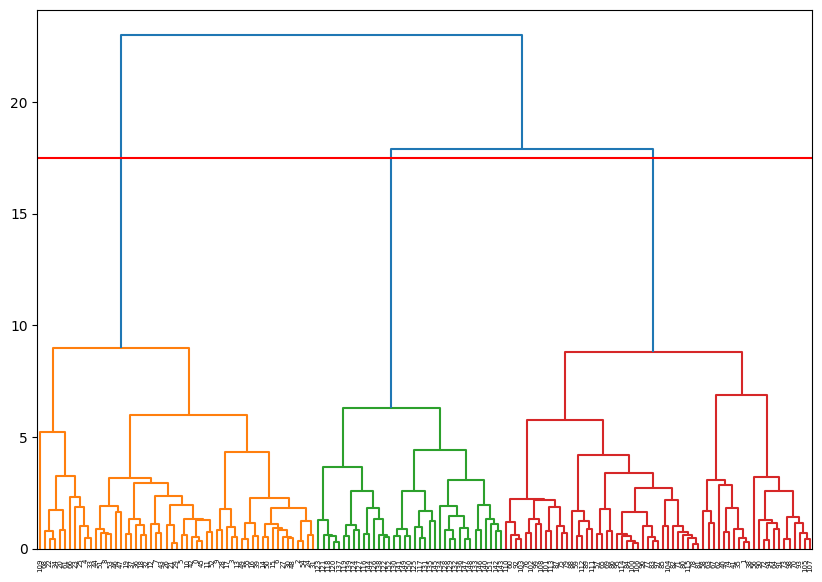

In [144]:
plt.figure(figsize=(10, 7))
shc.dendrogram(Z = clusters)
plt.axhline(y = 17.5, color = 'r', linestyle = '-')

Ahora vemos en un grafico la distribucion que tendrán los 3 cluster elegidos

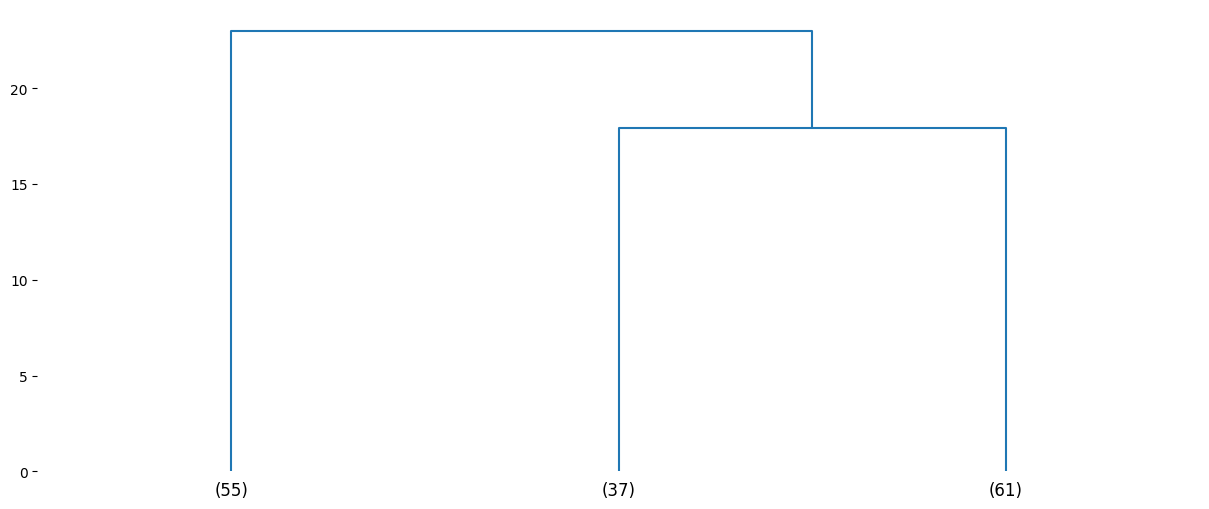

In [145]:
#Miramos cuantos elementos hay en cada cluster
plt.figure(figsize =(15,6))
dend = shc.dendrogram(clusters,
                 truncate_mode='lastp',
                 p = 3 # SUSTITUYE AQUI
                 )
sns.despine(left=True, bottom=True)

Ya que tenemos el hiperparámetro del numero de cluster seleccionado como 3 y el tipo de linkage como ward. Ahora aplicamos el algoritmo AgglomerativeClustering

In [155]:
from sklearn.cluster import AgglomerativeClustering

clustering_model = AgglomerativeClustering(n_clusters=3,metric="euclidean",linkage="ward")
clustering_model.fit(train_set)
clustering_model.labels_

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype=int64)

#### Entrenamiento, visualización de resultados con DBSCAN

In [156]:
df_empo["Cluster_jerarquico"] = clustering_model.labels_

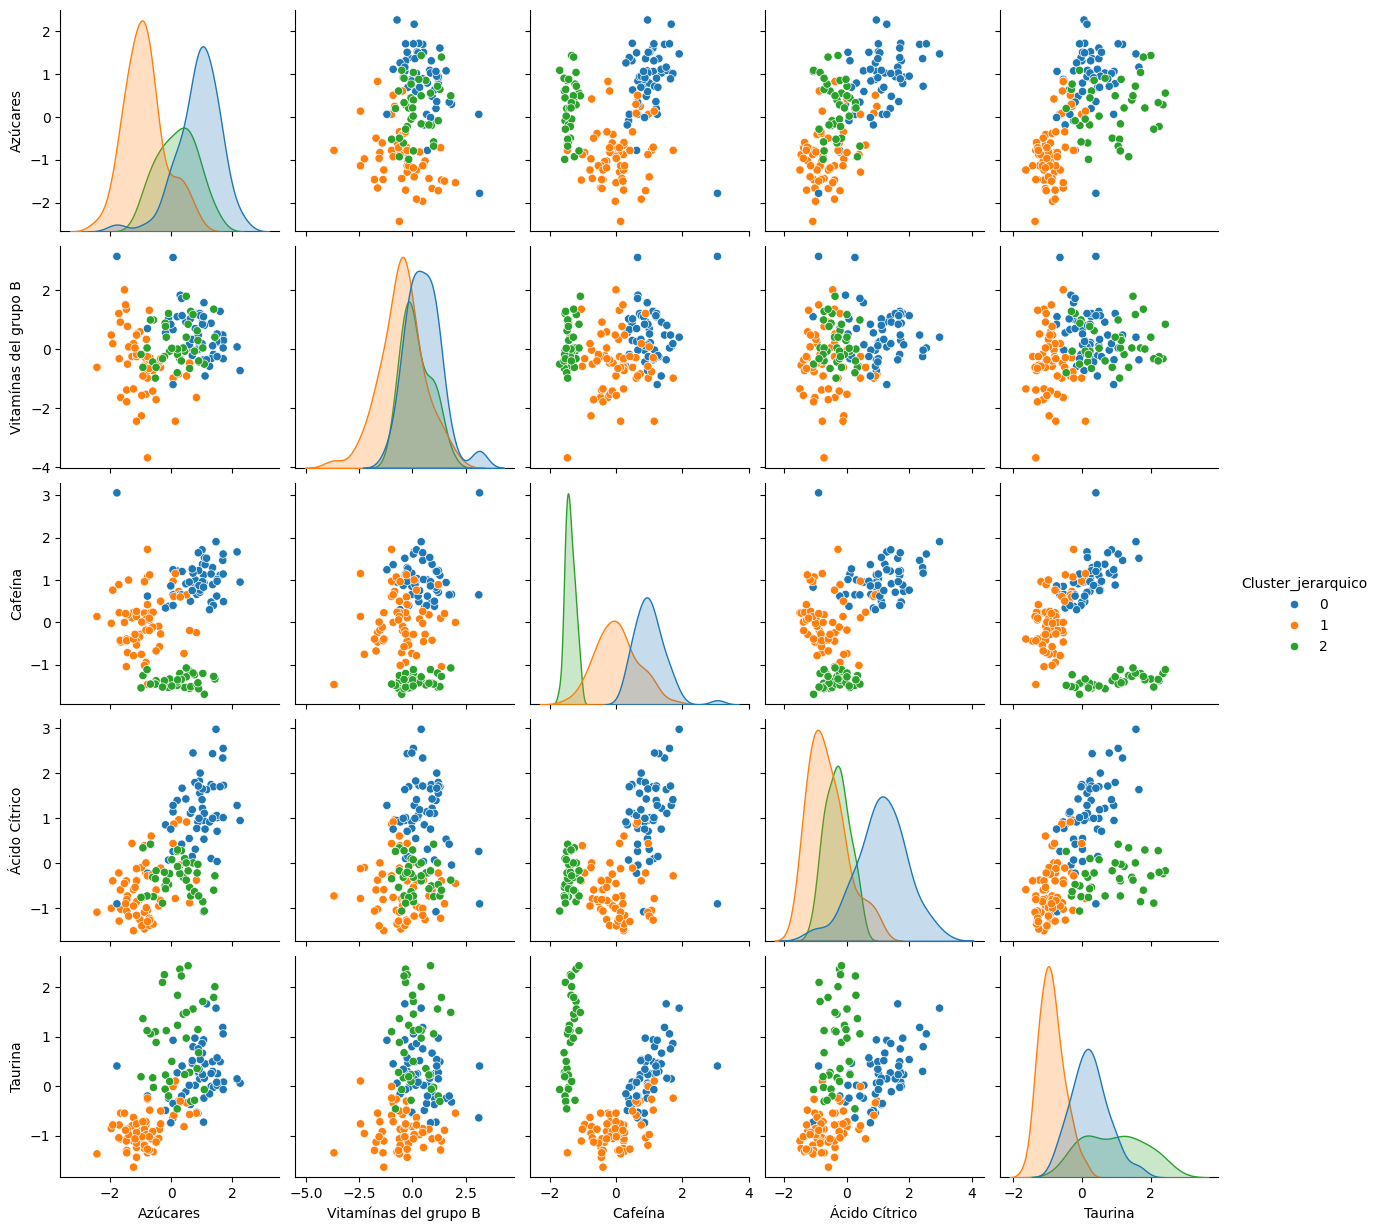

In [157]:
sns.pairplot(df_empo.drop("Cluster_dbscan",axis = 1),hue="Cluster_jerarquico",palette="tab10")

### Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

In [161]:
df_new = pd.read_csv("./data/new_experiments.csv",delimiter = "|")
df_new

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.481555,0.305159,1.366128,2.239039,0.731870
1,0.616869,0.890014,0.583034,0.312420,-0.665332
2,-1.680724,0.341713,-0.340615,-0.213021,-0.976782
3,-0.284874,-1.412851,-0.782361,-1.193845,-0.717240
4,-0.927212,0.634140,-1.565455,-0.085641,-0.522583
5,0.962743,-0.243142,-1.354622,-0.420013,1.956043


In [162]:
clustering_model.fit(df_new[features_sel])
clustering_model.labels_

array([0, 0, 1, 1, 1, 2], dtype=int64)

Vemos como nuestro modelo jerarquico etiqueta en diferentes clusters las nuevas instancias proporcionadas.

### Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentación de los modelos creados en la primera parte.

In [181]:
df_results = pd.read_csv("./data/power_results.csv")
df_results

,class
0,1
1,1
2,1
3,1
4,1
...,...
154,1
155,2
156,2
157,3


Concatemos los dos dataset para que tengamos los features de todas las instancias.  
Y agregamos al datafame los resultados que nos proporciona el Negocio

In [186]:
df_full = pd.concat([df_empo.drop(["Cluster_dbscan","Cluster_jerarquico"],axis = 1),df_new], axis = 0)
df_full["results"] = df_results
df_full

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina,results
0,1.518613,0.232053,1.034819,1.013009,0.251717,1
1,0.246290,-0.827996,0.733629,0.965242,-0.293321,1
2,0.196879,1.109334,1.215533,1.395148,0.269020,1
3,1.691550,0.487926,1.466525,2.334574,1.186068,1
4,0.295700,1.840403,0.663351,-0.037874,-0.319276,1
...,...,...,...,...,...,...
1,0.616869,0.890014,0.583034,0.312420,-0.665332,1
2,-1.680724,0.341713,-0.340615,-0.213021,-0.976782,1
3,-0.284874,-1.412851,-0.782361,-1.193845,-0.717240,1
4,-0.927212,0.634140,-1.565455,-0.085641,-0.522583,1


Visualizamos la segmentacion realizada por el negocio.

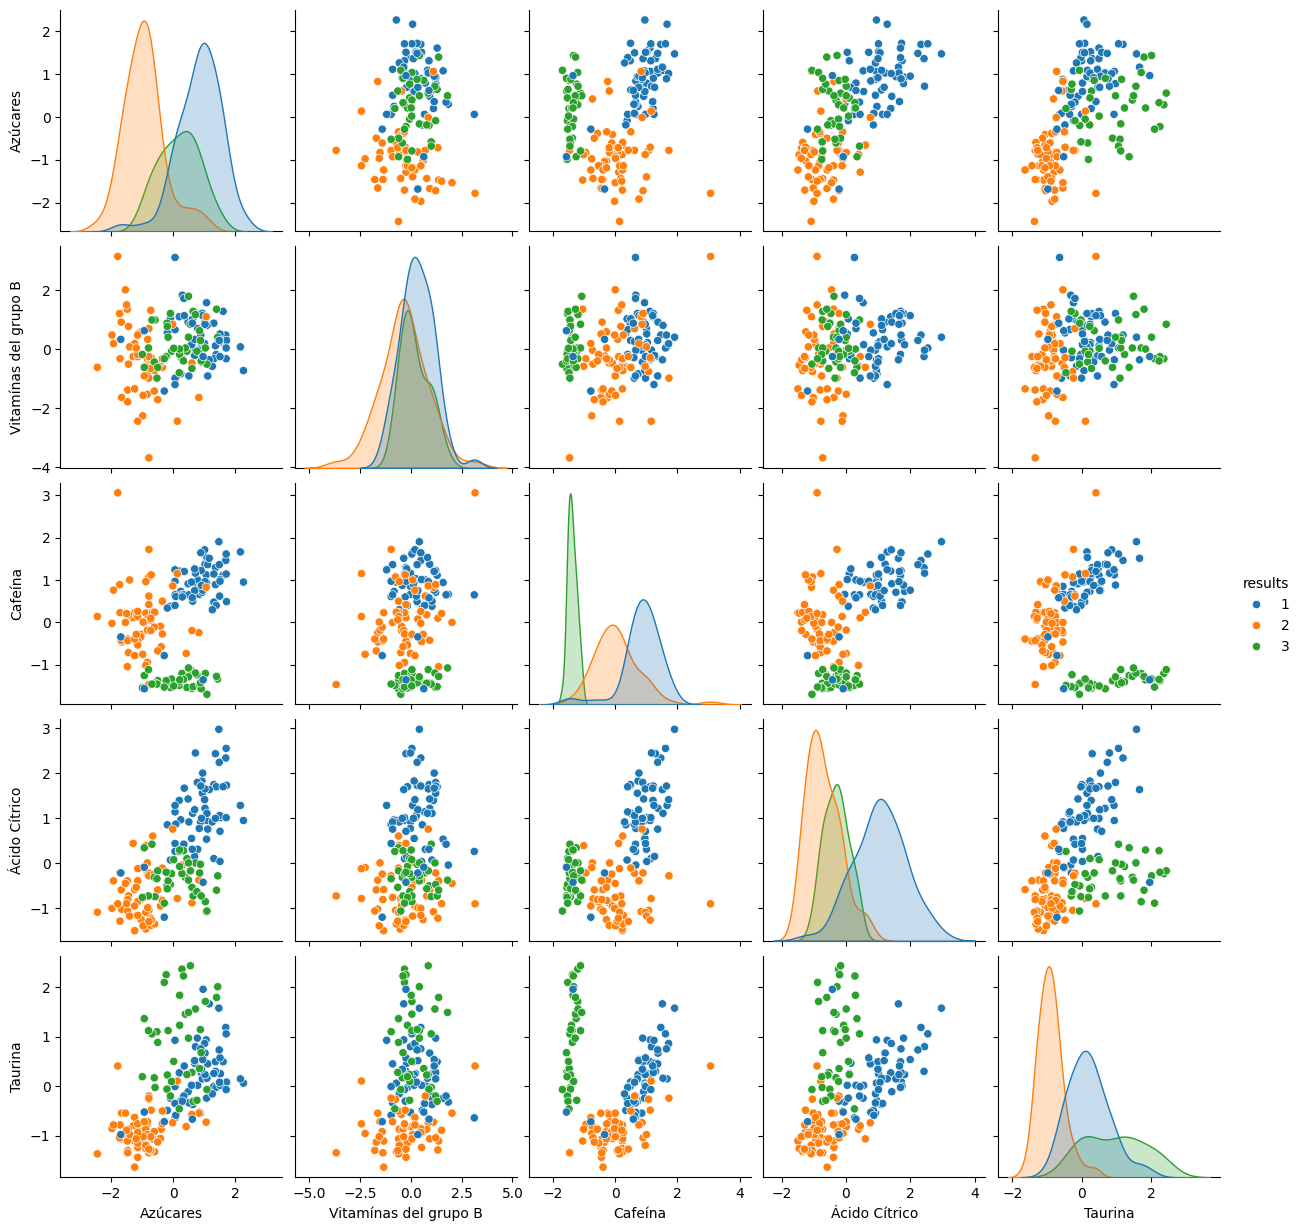

In [188]:
sns.pairplot(df_full, hue="results", palette="tab10")

Hacemos un analisis visual de la segmentacion del los resultados proporcionados por el Negocio. Vemos que son muy parecidos a nuestra segmentacion, especialmente la del cluster jerarquico aglomerativo.